In [0]:
import re
import gensim
import torch.nn as nn
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import seaborn as sns


In [2]:
!pip install -U -q PyDrive
import os  
os.chdir('/content/')  
!git clone https://github.com/ruelj2/Google_drive.git  

from Google_drive.handle import Google_drive  
Gd = Google_drive()  

fatal: destination path 'Google_drive' already exists and is not an empty directory.


In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session
from pydrive.auth import GoogleAuth     
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
Gd = Google_drive()  

In [0]:
json_import = drive.CreateFile({'id':'1Y0LdeAzisVk-2BVnoqY9eR61Ax3R6rKD'})
json_import.GetContentFile('GoogleNews-vectors-negative300.bin')

In [0]:
json_import1 = drive.CreateFile({'id':'1RQfHsaaFnEEz664YLKMxkTysRo8mAevS'})
json_import1.GetContentFile('emoji2vec.bin')

In [0]:
json_import1 = drive.CreateFile({'id':'1DXnuatRulmjPV0T3lQPu8oyDw_2f34pK'})
json_import1.GetContentFile('new_file.txt')

In [7]:
file_ID='1Y0LdeAzisVk-2BVnoqY9eR61Ax3R6rKD'
local_dir='/content'
Gd.load_file(local_dir, file_ID)

GoogleNews-vectors-negative300.bin loaded


In [8]:
file_ID='1RQfHsaaFnEEz664YLKMxkTysRo8mAevS'
local_dir='/content'
Gd.load_file(local_dir,file_ID)

emoji2vec.bin loaded


In [9]:
file_ID='1DXnuatRulmjPV0T3lQPu8oyDw_2f34pK'
Gd.load_file(local_dir,file_ID)

new_file.txt loaded


In [0]:
def read_file(file_name):
	data_list=[]
	with open(file_name,"r") as f:
		for line in f:
			line=line.strip()
			label=' '.join((line[line.find("[")+1:line.find("]")]).replace(',','').split())
			text=line[line.find("'")+1:line.find("')")].strip()
			data_list.append([label,text])
	return data_list

In [0]:
file_name="new_file.txt"
psychExp_txt=read_file(file_name)

In [0]:
w2v=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)
e2v=gensim.models.KeyedVectors.load_word2vec_format('emoji2vec.bin',binary=True)

In [0]:
##consider n-gram features
def ngram(token,n):
  output=[]
  for i in range(n-1,len(token)):
    ngram=' '.join(token[i-n+1:i+1])
    output.append(ngram)
  return output  

In [0]:
def create_feature(text,nrange=(1,1)):
  text_features=[]
  text=text.lower()
  text_alphanum=re.sub('[^a-z0-9#]',' ',text)
  for n in range(nrange[0],nrange[1]+1):
    text_features += ngram(text_alphanum.split(),n)
  return(text_features)  

In [0]:
def convert_label(item, name): 
    items = list(map(float, item.split()))
    label = ""
    for idx in range(len(items)): 
        if items[idx] == 1: 
            label += name[idx] + " "
    
    return label.strip()

In [0]:
emotions = ["😊", '😱', "😠", "😢", "😒", "😳", "😣"]

X_all = []
Y_all = []
for label, text in psychExp_txt:
    Y_all.append(torch.LongTensor(list(map(float,label.split()))))
    X_all.append(text)

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X_all,Y_all,test_size=0.2,random_state=123)

In [0]:
label_train=[]
label_test=[]
for i in Y_train:
  label_train.append(torch.nonzero(i).squeeze())
for i in Y_test:
  label_test.append(torch.nonzero(i).squeeze())
label_test=label_test

In [0]:
# build vocabulary 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
vocab=vectorizer.get_feature_names()

In [0]:
sentence_train=[]
for i in X_train:
  b=[]
  i=create_feature(i)
  for j in i:
    try:
      b.append(vocab.index(j))
    except ValueError:
      vocab.append(j)
      b.append(len(vocab)-1)
  sentence_train.append(torch.LongTensor(b))

In [0]:
sentence_test=[]
for i in X_test:
  b=[]
  i=create_feature(i)
  for j in i:
    try:
      b.append(vocab.index(j))
    except ValueError:
      b
  sentence_test.append(torch.LongTensor(b))

In [0]:
weights=np.zeros((len(vocab),300))
for i,word in enumerate(vocab):
  try:
    weights[i]=w2v[word]
  except KeyError:
    weights[i] = np.random.normal(scale=0.6, size=(300, ))
weights=torch.FloatTensor(weights)     

In [0]:
weights_emoji=np.zeros((len(emotions),300))
for i,emoji in enumerate(emotions):
  if emoji in e2v:
    weights_emoji[i]=e2v[emoji]
weights_emoji=torch.FloatTensor(weights_emoji)   

In [0]:
class CNNClassifier(nn.Module):
  def __init__(self,weight_matrix_of_word,weight_matrix_of_emoji,num_embeddings, embedding_dim, hidden_dim,target_size,kernel_size):
      super(CNNClassifier, self).__init__()
      self.kernel_size=kernel_size
      self.embedding_word=nn.Embedding.from_pretrained(weight_matrix_of_word)
      self.embedding_emoji=nn.Embedding.from_pretrained(weight_matrix_of_emoji,freeze=False)
      self.conv1=nn.Conv1d(embedding_dim,hidden_dim,kernel_size)
      self.conv2=nn.Conv1d(embedding_dim,hidden_dim,1)
      self.output=nn.Linear(hidden_dim,target_size)
      self.cos=nn.CosineSimilarity(dim=0)
    
#     super(CNNClassifier, self).__int__()
#     self.num_embeddings =num_embeddings
#     self.embedding_dim = embedding_dim
#     self.target_size = target_size  
#     self.embedding_word=nn.Embedding(num_embeddings,embedding_dim)
#     self.convs = nn.ModuleList([nn.Conv2d(channel,knum,(K,embedding_dim)) for K in kernel_size]) 
#     self.linear=nn.Linear(len(kernel_size)*knum,target_size)

  def forward(self,sentence):
    x=self.embedding_word(sentence).view(1,len(sentence),-1).transpose(1,2)
    emoji=self.embedding_emoji.weight
    if(len(sentence)>=self.kernel_size):
      c=self.conv1(x)
      pool1=nn.MaxPool1d(len(sentence)-self.kernel_size+1)
    else:
      c=self.conv2(x)
      pool1=nn.MaxPool1d(len(sentence))
    c=F.relu(c)  
    p=pool1(c).view(1,-1)
    out=self.output(p)
    a=torch.zeros(1,len(emoji))
    for i,j in enumerate(emoji):
      for p,q in enumerate(out):
        a[p][i]=self.cos(q,j)
    return a

In [0]:
def accuracy(test_text,test_label,Model,batch_size=1):
  total=len(test_label)
  correct=0
  for sentence,labels in zip(test_text,test_label):
    output=torch.argmax(Model(sentence))
    correct += (output==labels).sum()
  return float(correct)/total  

In [0]:
def metrics(test_text,test_label,Model,batch_size=1):
  a=np.array(test_label)
  b=np.zeros(len(test_label))
  for i,sentence in enumerate(test_text):
    predict=torch.argmax(Model(sentence))
    b[i]=predict
  F1=f1_score(a,b,average=None)
  F1_total = f1_score(a,b,average='macro')
  rscore=recall_score(a,b,average=None)
  rscore_total=recall_score(a,b,average='macro')
  pscore=precision_score(a,b,average=None)
  pscore_total=precision_score(a,b,average='macro')
  print("F1:"+str(F1))
  print("recall_score:"+str(rscore))
  print("precision_score:"+str(pscore))
  print("F1_toal:"+str(F1_total))
  print("rscore_total:"+str(rscore_total))
  print("pscore_total:"+str(pscore_total))

In [126]:
### Train the CNN model
model=CNNClassifier(weights,weights_emoji,len(vocab),300,200,300,2)
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0)
epoch_accuracies = []
best_accuracy=0
for epoch in range(1000):
  i=0
  for sentence,labels in zip(sentence_train,label_train):
    i=i+1
    optimizer.zero_grad()
    outputs=model(sentence)
    labels=labels.unsqueeze(dim=0)
    loss=loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    if (i+1)%1000==0:
              print ('Epoch: [%d/%d], Step: [%d/%d] , Loss: %.4f, Dev: %.4f' 
                     % (epoch+1, 1000, i+1, len(sentence_train), 
                        loss.data, accuracy(sentence_train,label_train,model)))
  epoch_accuracies.append(accuracy(sentence_test,label_test,model))
  if epoch_accuracies[-1] > best_accuracy:
    best_accuracy = epoch_accuracies[-1]
    best_epoch = epoch
  if(epoch>=10 and epoch_accuracies[-1]<=epoch_accuracies[-10]):
    break                %%!%%!%%!
  # TODO: implement early stopping here      
  print(best_accuracy, best_epoch)

Epoch: [1/1000], Step: [1000/187] , Loss: 2.2984, Dev: 0.1791
Epoch: [1/1000], Step: [2000/187] , Loss: 1.9626, Dev: 0.1942
Epoch: [1/1000], Step: [3000/187] , Loss: 1.8747, Dev: 0.2176
Epoch: [1/1000], Step: [4000/187] , Loss: 1.9259, Dev: 0.2258
Epoch: [1/1000], Step: [5000/187] , Loss: 2.1052, Dev: 0.2433
0.28475935828877 0
Epoch: [2/1000], Step: [1000/187] , Loss: 1.8740, Dev: 0.4794
Epoch: [2/1000], Step: [2000/187] , Loss: 1.1178, Dev: 0.4871
Epoch: [2/1000], Step: [3000/187] , Loss: 1.4781, Dev: 0.5565
Epoch: [2/1000], Step: [4000/187] , Loss: 1.9629, Dev: 0.5809
Epoch: [2/1000], Step: [5000/187] , Loss: 1.2014, Dev: 0.6034
0.5340909090909091 1
Epoch: [3/1000], Step: [1000/187] , Loss: 1.7711, Dev: 0.6240
Epoch: [3/1000], Step: [2000/187] , Loss: 1.0951, Dev: 0.6282
Epoch: [3/1000], Step: [3000/187] , Loss: 1.2792, Dev: 0.6583
Epoch: [3/1000], Step: [4000/187] , Loss: 1.9308, Dev: 0.6705
Epoch: [3/1000], Step: [5000/187] , Loss: 1.1346, Dev: 0.6952
0.554144385026738 2
Epoch: [4/

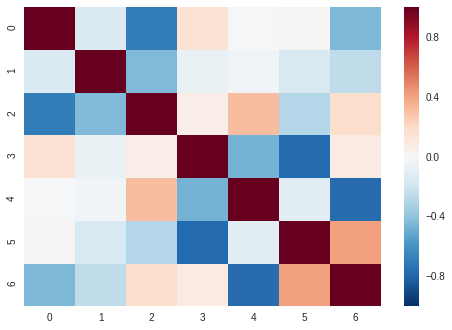

In [127]:
a=(list(model.parameters()))[1].data
b=np.array(a)
corr=np.corrcoef(b)
ax=sns.heatmap(corr)

In [156]:
metrics(sentence_test,label_test,model)

F1:[0.59677419 0.66326531 0.4137931  0.60944206 0.50596659 0.43333333
 0.50943396]
recall_score:[0.7014218  0.58035714 0.39473684 0.6367713  0.5492228  0.3919598
 0.49541284]
precision_score:[0.51929825 0.77380952 0.43478261 0.58436214 0.46902655 0.48447205
 0.52427184]
F1_toal:0.5331440779878007
rscore_total:0.5356975039025482
pscore_total:0.5414318515798726


In [0]:
def Demo():
  sentence=input("Please type here:")
  sentence=create_feature(sentence)
  b=[]
  for i in sentence:
    try:
      b.append(vocab.index(i))
    except ValueError:
      b
  b=torch.LongTensor(b)    
  output=model(b)
  predict=torch.argmax(output)
  return emotions[predict]
  
  
  
  

In [97]:
Demo()

Please type here:I said something bad behind my classmate's back which is totally wrong


'😳'

In [164]:
checkpoint = {'model': CNNClassifier(weights,weights_emoji,len(vocab),300,200,300,2),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CNNClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model1 = load_checkpoint('checkpoint.pth')


In [0]:
torch.save(vocab,"vocab.pth")